# Divide video
The task in this project is to estimate strain in a basal segment by tracking two points between the end-diastole and end-systole frames in cardiac ultrasound videos. We assume that we have a method of detecting ED and ES frames in the ultrasound videos. Then, we need videos that are from ED to ES only.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import glob
import os
# Be able to import from src folder
PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
print(PROJ_ROOT)
import sys
sys.path.append(os.path.join(PROJ_ROOT, 'src'))

import misc.notebookHelpers

%matplotlib inline
%config InlineBackend.figure_format = "retina"

plt.rcParams['figure.figsize'] = (10, 10)

/Users/torjushaukom/Documents/Studier/Masteroppgave/Strain_estimation


In [3]:
data_path = os.path.join(PROJ_ROOT, 'data/processed/mitral_point_labeled/')
file_paths = glob.glob(os.path.join(data_path, '*/*.h5'))

In [20]:
file_paths[26]

'/Users/torjushaukom/Documents/Studier/Masteroppgave/Strain_estimation/data/processed/mitral_point_labeled/p3/I599G5GA.h5'

In [21]:
h5file = h5py.File(file_paths[26])
print([k for k in h5file['tissue'].keys()])

['data', 'dirx', 'diry', 'ds_labels', 'mitral_points', 'origin', 'pixelsize', 'times']


In [22]:
h5file['TVI/times']

KeyError: "Unable to open object (object 'times' doesn't exist)"

Do a little quality check and see the first es and ed image

In [5]:
first_ed = np.where(h5file['tissue/ds_labels'][:] == 1.0)[0][0]
first_ed

7

In [6]:
first_es = np.where(h5file['tissue/ds_labels'][first_ed:] == 2.0)[0][0]
first_es

9

In [7]:
video, fps = misc.notebookHelpers.video_and_fps_from_h5py(h5file)

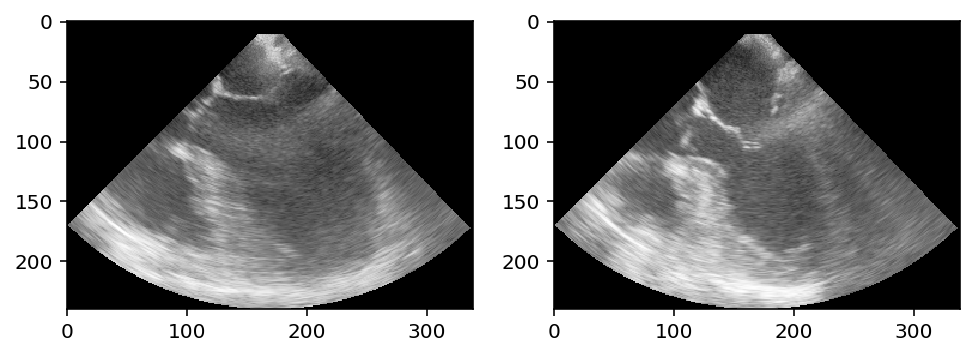

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 16))
ax[0].imshow(video[first_ed, :, :], cmap='Greys_r')
ax[1].imshow(video[first_es + first_ed, :, :], cmap='Greys_r')

Looks all right, find the indicises of every ED with a following ES

In [9]:
full_ed_idc = np.where(h5file['tissue/ds_labels'][:] == 1.0)[0]
ed_idc = []
es_idc = []

for ed_idx in full_ed_idc:
    remaining_es = np.where(h5file['tissue/ds_labels'][ed_idx:] == 2.0)[0]
    if remaining_es.size > 0:
        next_es = remaining_es[0] + ed_idx
        es_idc.append(next_es)
        ed_idc.append(ed_idx)
    else:
        break

In [10]:
ed_idc

[7, 25, 42, 60, 78, 96]

In [11]:
es_idc

[16, 34, 51, 69, 87, 105]

Check that we in fact have indices from the first ED to the last ES

<StemContainer object of 3 artists>

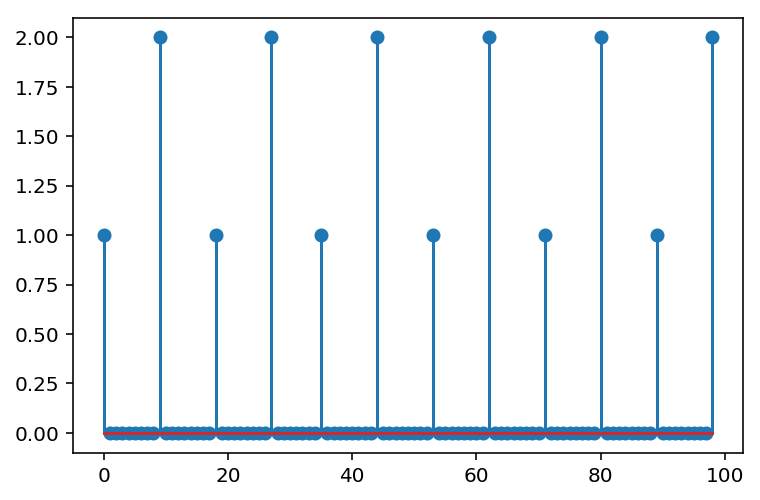

In [12]:
vis_arr = np.zeros(es_idc[-1] - ed_idc[0] + 1)
vis_arr[ed_idc - ed_idc[0]] = 1
vis_arr[es_idc - ed_idc[0]] = 2

plt.stem(vis_arr)

Try to view a clip for quality assurance

In [13]:
clip = video[ed_idc[3]:es_idc[3] + 1, :, :]
misc.notebookHelpers.ultraSoundAnimation(clip, fps=fps / 8)

Looks good, now find corresponding TVI frames to keep them with the dataset

In [14]:
tvi_ed_idc = []
tvi_es_idc = []
for ed_idx, es_idx in zip(ed_idc, es_idc):
    ed_time = h5file['tissue/times'][ed_idx]
    es_time = h5file['tissue/times'][es_idx]
    
    tvi_ed_idx = np.argmin(np.abs(h5file['TVI/times'] - ed_time))
    tvi_es_idx = np.argmin(np.abs(h5file['TVI/times'] - es_time))
    
    tvi_ed_idc.append(tvi_ed_idx)
    tvi_es_idc.append(tvi_es_idx)


In [15]:
tvi_video, tvi_fps = misc.notebookHelpers.video_and_fps_from_h5py(h5file, 'tvi')
tvi_clip = tvi_video[tvi_ed_idc[3]:tvi_es_idc[3] + 1, :, :]
misc.notebookHelpers.ultraSoundAnimation(tvi_clip, fps=tvi_fps / 8)

In [ ]:
print([k for k in h5file['tissue'].keys()])
print([k for k in h5file['TVI'].keys()])

In [ ]:
print([v for v in h5file['tissue/pixelsize']])

Try to make new files containing one video segment from ED to ES each. Add TVI, pixel information, directions, origin and timing for TVI and B-mode

In [18]:
new_file_name_base = file_paths[10].split('/')[-1][:-3]
new_file_folder = '../data/interim/'
for i, _ in enumerate(ed_idc):
    new_file = h5py.File(
        os.path.join(new_file_folder, 
                     new_file_name_base + f'_{i}_.h5'), 
        'w')
    ed_idx = ed_idc[i]
    es_idx = es_idc[i]
    
    ed_time = h5file['tissue/times'][ed_idx]
    es_time = h5file['tissue/times'][es_idx]
    
    video = h5file['tissue/data'][:]
    clip = video[:, :, ed_idx:es_idx + 1]
    clip_times = h5file['tissue/times'][ed_idx:es_idx + 1]
    
    tissue = new_file.create_group('tissue')
    tissue.create_dataset('data', data=clip)
    tissue.create_dataset('times', data=clip_times)
    tissue.create_dataset('dirx', data=h5file['tissue/dirx'])
    tissue.create_dataset('diry', data=h5file['tissue/diry'])
    tissue.create_dataset('pixelsize', data=h5file['tissue/pixelsize'])
    tissue.create_dataset('origin', data=h5file['tissue/origin'])
    tissue.create_dataset('mitral_points', data=h5file['tissue/mitral_points'])
    try:
        tvi_ed_idx = np.argmin(np.abs(h5file['TVI/times'] - ed_time))
        tvi_es_idx = np.argmin(np.abs(h5file['TVI/times'] - es_time))
        
        tvi_video = h5file['TVI/data'][:]
        tvi_clip = tvi_video[:, :, tvi_ed_idx:tvi_es_idx + 1]
        tvi_clip_times = h5file['TVI/times'][ed_idx:es_idx + 1]
        
        tvi = new_file.create_group('TVI')
        tvi.create_dataset('data', data=tvi_clip)
        tvi.create_dataset('times', data=tvi_clip_times)
        # Directions swapped after transpose
        tvi.create_dataset('dirx', data=h5file['TVI/diry'])
        tvi.create_dataset('diry', data=h5file['TVI/dirx'])
        tvi.create_dataset('pixelsize', data=h5file['TVI/pixelsize'])
        tvi.create_dataset('origin', data=h5file['TVI/origin'])
    except:
        print(f'{new_file_name_base} is missing TVI/times, skip TVI for this file')
    new_file.close()

Try to open one of them to check that it went according to plan

In [ ]:
test_file = h5py.File(os.path.join(new_file_folder, 
                                      new_file_name_base + f'_{3}_.h5'))

In [ ]:
misc.ultraSoundAnimation(test_file['tissue/data'], fps=24)

In [ ]:
misc.ultraSoundAnimation(test_file['TVI/data'], fps=24)